# Размещение баннеров

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

In [155]:
data = pd.read_csv('checkins.dat', sep='|', skipinitialspace=True).dropna()

C:\Users\Alexey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [156]:
data.columns

Index(['id    ', 'user_id ', 'venue_id ', 'latitude      ', 'longitude     ',
       'created_at      '],
      dtype='object')

In [157]:
data.columns = data.columns.str.strip()

In [158]:
data.head()

,id,user_id,venue_id,latitude,longitude,created_at
2,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
4,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
8,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
10,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
11,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [159]:
data.tail()

,id,user_id,venue_id,latitude,longitude,created_at
1021960,955561,626076.0,20073.0,40.850100,-73.866246,2012-04-13 09:56:48
1021961,955892,674797.0,2297.0,33.748995,-84.387982,2012-04-13 10:56:03
1021962,956377,845102.0,11195.0,42.765366,-71.467566,2012-04-13 12:08:45
1021963,956119,1139114.0,29488.0,42.439479,-83.743830,2012-04-13 11:36:44
1021965,956733,960666.0,60.0,42.331427,-83.045754,2012-04-13 21:56:19


Убедимся, что все 396634 строки с координатами считаны успешно.

In [160]:
data.shape

(396634, 6)

Понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем.

In [161]:
data = data[['latitude', 'longitude']]

In [162]:
data_sample = data.sample(100000)

In [223]:
data_sample.head()

,latitude,longitude
930527,40.714353,-74.005973
280034,41.878114,-87.629798
1013379,34.282872,-84.745214
786841,45.523452,-122.676207
136717,39.290385,-76.612189


Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

In [163]:
from sklearn.cluster import MeanShift

In [164]:
ms = MeanShift(bandwidth = 0.1, n_jobs = -1)
ms.fit(data_sample)

MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
          n_jobs=-1, seeds=None)

Из документации по MeanShift, после обучения доступны два атрибута:

* cluster_centers_ - массив, содержащий центры кластеров, в нашем случае, пары координат, без указания меток кластеров. Длина массива соответствует количеству кластеров.
* labels_ - массив, содержащий метки кластеров для исходной выборки. Длина соответствует размеру исходной выборки.

In [170]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(labels)
print(cluster_centers)

[   0    1 1369 ...   86  226    0]
[[ 4.07176100e+01 -7.39893759e+01]
 [ 4.18781382e+01 -8.76298101e+01]
 [ 3.34484827e+01 -1.12074116e+02]
 ...
 [-4.12924945e+01  1.74773235e+02]
 [-4.50311622e+01  1.68662644e+02]
 [-7.52509730e+01 -7.13890000e-02]]


In [167]:
print(labels.shape)
print(cluster_centers.shape)

(100000,)
(3573, 2)


Отберем уникальные метки кластеров и подсчитаем количество центров скопления туристов в каждом из кластеров

In [201]:
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique)
print(counts)

[   0    1    2 ... 3570 3571 3572]
[14037  3888  2792 ...     1     1     1]


In [175]:
centers_count = list(zip(labels_unique, counts))
print(centers_count[:5])

[(0, 14037), (1, 3888), (2, 2792), (3, 2315), (4, 2801)]


Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

In [178]:
centers_count_15 = [center for center in centers_count if center[1] > 15]
print(centers_count_15[:5])
len(centers_count_15)

[(0, 14037), (1, 3888), (2, 2792), (3, 2315), (4, 2801)]


594

Отсортируем кластеры по количеству центров скопления туристов

In [180]:
centers_count_15.sort(key = lambda x: x[1], reverse = True)
print(centers_count_15[:5])

[(0, 14037), (1, 3888), (4, 2801), (2, 2792), (3, 2315)]


Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

In [182]:
offices_coords = np.array([[33.751277, -118.188740], 
                     [25.867736, -80.324116], 
                     [51.503016, -0.075479], 
                     [52.378894, 4.885084], 
                     [39.366487, 117.036146], 
                     [-33.868457, 151.205134]])

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

In [205]:
distanсe_list = []
for center in centers_count_15:
    for office_coords in offices_coords:
        center_coords = cluster_centers[center[0]]
        distanсe = np.linalg.norm(office_coords-center_coords)
        distanсe_list.append((distanсe, center[0]))

In [206]:
distanсe_list.sort()

In [207]:
distanсe_list[:20]

[(0.004742162515251734, 241),
 (0.009454812450576649, 351),
 (0.02533886713634221, 299),
 (0.052063524546886134, 62),
 (0.07258903832865084, 50),
 (0.13476290081438078, 23),
 (0.17972117394803774, 89),
 (0.20368418976227684, 86),
 (0.20621288467415946, 184),
 (0.21596287163688394, 42),
 (0.265382322559162, 49),
 (0.29259342305899094, 55),
 (0.30145140136988097, 31),
 (0.31472331572090834, 14),
 (0.3571106673224435, 65),
 (0.3575966780072676, 35),
 (0.36766390850450315, 100),
 (0.3750508941918367, 18),
 (0.3833399948760821, 47),
 (0.3837818482716318, 136)]

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса.

In [198]:
cluster_centers[distanсe_list[0][1]]

array([-33.86382167, 151.20613489])

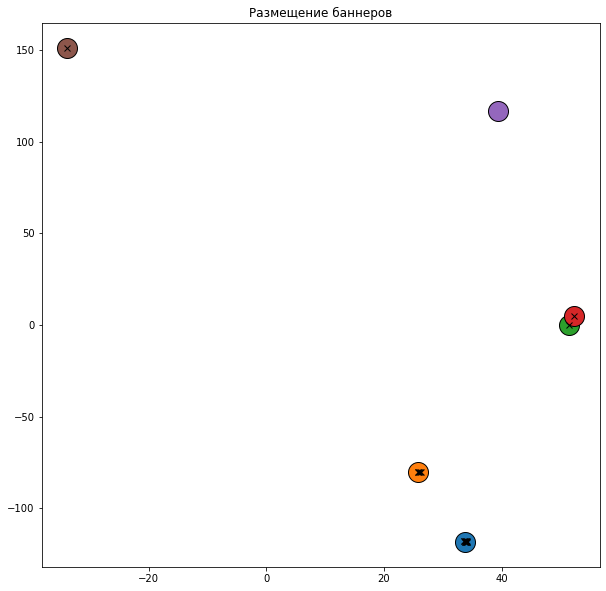

In [295]:
plt.figure(figsize=(10,10))
for k in range(len(offices_coords)):
    plt.plot(offices_coords[k][0], offices_coords[k][1], 'o', markeredgecolor='k', markersize=20)
for k in range(len(distanсe_list[:20])):
    plt.plot(cluster_centers[distanсe_list[k][1]][0], cluster_centers[distanсe_list[k][1]][1], 'x', color='black')
plt.title('Размещение баннеров')
plt.show()